### Part 3: Obtaining and comparing predictions using the three models (BP, BP-F, MLR-F)
First we'll make all the necessary imports needed in this part:

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from NeuralNet import NeuralNet

Then we make a function to calculate all the different metrics needed in this section. In this case, the metrics are:
- MSE - Mean Squared Error
- MAE - Mean Absolute Error
- MAPE - Mean Absolute Percentage Error

In [33]:
def compute_metrics(y_true, y_pred):
    """
    Compute MSE, MAE, and MAPE using scikit-learn.
    Returns the three metrics as floats.
    """
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100  # convert to %
    
    return mse, mae, mape

def denormalize(arr_scaled, col='SalePrice'):
    """
    Inverse transform matching normalization:
    scaled = 0.1 + 0.8 * (orig - abs_min) / (abs_max - abs_min)
    so inverse: orig = abs_min + (scaled - 0.1)/0.8 * (abs_max - abs_min)
    """
    mn, mx = min_max[col]
    arr_scaled = np.asarray(arr_scaled).ravel()
    return mn + (arr_scaled - 0.1) / 0.8 * (mx - mn)

# BP-F (PyTorch)
class TorchNet(nn.Module):
    def __init__(self, layers, activation="relu"):
        # layers: list defining NN architecture
        # activation : string ('relu', 'tanh', 'sigmoid')
        super().__init__()

        # Dictionary of activation functions
        # We map the string name to the actual PyTorch module
        act_map = {
            'relu': nn.ReLU(),
            'tanh': nn.Tanh(),
            'sigmoid': nn.Sigmoid()
        }
        # Save chosen activation for hidden layers
        activation_fn = act_map[activation]

        # Build a list of layers for the network automatically
        layer_list = []
        # We iterate through pairs of (in_features, out_features)
        for i in range(len(layers) - 1):
            # Add a connected Linear layer from layer[i] to layer[i+1]
            layer_list.append(nn.Linear(layers[i], layers[i + 1]))

            # Add activation to all layers except the last output layer, as the output should remain linear without activation
            if i < len(layers) - 2:
                layer_list.append(activation_fn)
                
        # Creates a single model where layers run in order.        
        self.model = nn.Sequential(*layer_list)

    def forward(self, x):
        # Pass input through the entire model in sequence
        return self.model(x)

df = pd.read_csv('data_clean.csv')
df = df.select_dtypes(include = ['float64', 'int64'])

#store the min and the max of each column to denormalize the data later
min_max = {}
for column in df.columns:
    min_max[column] = [df[column].abs().min(), df[column].abs().max()]

# normalize all the data of the dataframe between 0 and 1
df_scaled = df.copy()

#normalize the data between 0 and 1 using the min_max dictionary
for column in df_scaled.columns:
    df_scaled[column] = 0.1 + 0.8 * (df_scaled[column] - min_max[column][0]) / (min_max[column][1] - min_max[column][0])

y = df_scaled['SalePrice'].values
X = df_scaled.drop('SalePrice', axis=1).values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(y)

# Definition of hyperparameters
hyperparams = [
    {'layers':[X_train.shape[1], 8, 1], 'activation':'relu', 'lr':0.01, 'momentum':0.0, 'epochs':150},
    {'layers':[X_train.shape[1], 8, 1], 'activation':'tanh', 'lr':0.01, 'momentum':0.9, 'epochs':200},
    {'layers':[X_train.shape[1], 16, 8, 1], 'activation':'relu','lr':0.005,'momentum':0.8, 'epochs':250},
    {'layers':[X_train.shape[1], 16, 1], 'activation':'sigmoid','lr':0.01,'momentum':0.8, 'epochs':200},
    {'layers':[X_train.shape[1], 32, 16, 1], 'activation':'relu','lr':0.001,'momentum':0.9,'epochs':300},
    {'layers':[X_train.shape[1], 4, 1], 'activation':'tanh','lr':0.02,'momentum':0.0,'epochs':150},
    {'layers':[X_train.shape[1], 10, 5, 1], 'activation':'relu','lr':0.01,'momentum':0.8,'epochs':200},
    {'layers':[X_train.shape[1], 20, 10, 1], 'activation':'tanh','lr':0.005,'momentum':0.7,'epochs':250},
    {'layers':[X_train.shape[1], 12, 1], 'activation':'relu','lr':0.02,'momentum':0.9,'epochs':180},
    {'layers':[X_train.shape[1], 6, 3, 1], 'activation':'tanh','lr':0.001,'momentum':0.6,'epochs':300},
]

results_list = []

# Custom BP
custom_results = []         # store ALL hyperparameter results
best_mse_bp = np.inf        # track best result
best_metrics_bp = None      # store the best

for params in hyperparams:
    nn_model = NeuralNet(layers = params['layers'], epochs = params['epochs'], learning_rate = params['lr'], momentum = params['momentum'],
        function = params['activation'],
        validation_split = 0.2
    )

    # Train the model
    nn_model.fit(X_train, y_train)
    pred_train_bp_scaled = nn_model.predict(X_train)
    pred_test_bp_scaled  = nn_model.predict(X_test)

    # Denormalize the data obtained
    pred_train_bp = denormalize(pred_train_bp_scaled.flatten(), 'SalePrice')
    pred_test_bp = denormalize(pred_test_bp_scaled.flatten(), 'SalePrice')
    y_train_den = denormalize(y_train, 'SalePrice')
    y_test_den = denormalize(y_test, 'SalePrice')
    
    mse_bp, mae_bp, mape_bp = compute_metrics(y_test_den, pred_test_bp)

    # Extract losses
    train_losses_bp, val_losses_bp = nn_model.loss_epochs()

    # Save this run (NOT ONLY THE BEST)
    run_result = {
        'Model': 'BP (Custom NN)',
        'Layers': params['layers'],
        'Activation': params['activation'],
        'Learning Rate': params['lr'],
        'Momentum': params['momentum'],
        'Epochs': params['epochs'],
        'MSE Test': mse_bp,
        'MAE Test': mae_bp,
        'MAPE Test (%)': mape_bp,
        'Pred Train': pred_train_bp,
        'Pred Test': pred_test_bp,
        'Train Losses': train_losses_bp,
        'Test Losses': val_losses_bp
    }

    custom_results.append(run_result)
    
    # Save if best by test MSE
    if mse_bp < best_mse_bp:
        best_mse_bp = mse_bp
        best_metrics_bp = run_result
        
results_list.append(best_metrics_bp)

# MLR model
mlr = LinearRegression()
mlr.fit(X_train, y_train)
pred_mlr_train_scaled = mlr.predict(X_train)
pred_mlr_test_scaled = mlr.predict(X_test)

# Denormalize the data obtained
pred_mlr_train = denormalize(pred_mlr_train_scaled, 'SalePrice')
pred_mlr_test = denormalize(pred_mlr_test_scaled, 'SalePrice')
y_train_den = denormalize(y_train, 'SalePrice')
y_test_den = denormalize(y_test, 'SalePrice')

mse_mlr, mae_mlr, mape_mlr = compute_metrics(y_test_den, pred_mlr_test)

# Append MLR row
results_list.append({
    'Model': 'MLR-F (Linear Regression)',
    'Layers': None,
    'Activation': None,
    'Learning Rate': None,
    'Momentum': None,
    'Epochs': None,
    'MSE Test': mse_mlr,
    'MAE Test': mae_mlr,
    'MAPE Test (%)': mape_mlr,
    'Pred Train': pred_mlr_train,
    'Pred Test': pred_mlr_test,
    'Train Losses': None,
    'Test Losses': None
})
# Evaluate the different hyperparameters for each model
best_mse_bpf = np.inf
best_metrics_bpf = None
                 
# Convert data to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32)

for params in hyperparams:
    # BP-F (TorchNet)
    model = TorchNet(params['layers'], activation=params['activation'])
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=params['lr'], momentum=params['momentum'])
    train_losses = []
    test_losses = []
    #Training of the model
    for epoch in range(params['epochs']):
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        optimizer.zero_grad()
        
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        model.eval()
        with torch.no_grad():
            val_loss = criterion(model(X_test_tensor), y_test_tensor).item()
        test_losses.append(val_loss)

    model.eval()
    # Predict on train and test
    with torch.no_grad():
        pred_train_tensor_scaled = model(X_train_tensor).numpy().flatten()
        pred_test_tensor_scaled = model(X_test_tensor).numpy().flatten()

    # Denormalize the data obtained
    pred_train_bpf = denormalize(pred_train_tensor_scaled, 'SalePrice')
    pred_test_bpf  = denormalize(pred_test_tensor_scaled, 'SalePrice')
    y_train_den = denormalize(y_train, 'SalePrice')
    y_test_den  = denormalize(y_test, 'SalePrice')
    
    # Compute the different metrics
    mse_bp_f, mae_bp_f, mape_bp_f = compute_metrics(y_test_den, pred_test_bpf)
    # keep best by test MSE
    if mse_bp_f < best_mse_bpf:
        best_mse_bpf = mse_bp_f
        best_metrics_bpf = {
            'Model': 'BP-F (Library NN)',
            'Layers': params['layers'],
            'Activation': params['activation'],
            'Learning Rate': params['lr'],
            'Momentum': params['momentum'],
            'Epochs': params['epochs'],
            'MSE Test': mse_bp_f,
            'MAE Test': mae_bp_f,
            'MAPE Test (%)': mape_bp_f,
            'Pred Train': pred_train_bpf,
            'Pred Test': pred_test_bpf,
            'Train Losses': train_losses,
            'Test Losses': test_losses
        }

results_list.append(best_metrics_bpf)

def format_layers(layers):
    # If it's from the mlr model
    if layers is None:
        return "Not applicable"
    return "-".join(str(x) for x in layers)

def readable_value(value):
    # If the key is missing return "N/A"
    if value == "N/A":
        return "N/A"

    # If the key exists but is None (like for MLR) return "Not applicable"
    if value is None:
        return "Not applicable"

    # Else return the actual value if neither case from above applies
    return value

# Build final tidy table
display_rows = []
for result in results_list:
    row = {
        "Model": result["Model"],
        "Layers": format_layers(result.get("Layers")),
        "Activation": readable_value(result.get("Activation", "N/A")),
        "Learning Rate": readable_value(result.get("Learning Rate", "N/A")),
        "Momentum": readable_value(result.get("Momentum", "N/A")),
        "Epochs": readable_value(result.get("Epochs", "N/A")),
        "MSE Test": result["MSE Test"],
        "MAE Test": result["MAE Test"],
        "MAPE Test (%)": result["MAPE Test (%)"]
    }
    display_rows.append(row)


results_df = pd.DataFrame(display_rows).round(4)

display(results_df)

[0.59582292 0.5187076  0.63866476 ... 0.76147804 0.40624777 0.42159943]
Epoch 0/150 - Training Error: 0.032494 - Validation Error: 0.029435
Epoch 100/150 - Training Error: 0.004867 - Validation Error: 0.003708
Epoch 0/200 - Training Error: 0.017004 - Validation Error: 0.016584
Epoch 100/200 - Training Error: 0.003861 - Validation Error: 0.003460
Epoch 0/250 - Training Error: 0.013395 - Validation Error: 0.013986
Epoch 100/250 - Training Error: 0.002793 - Validation Error: 0.002901
Epoch 200/250 - Training Error: 0.002448 - Validation Error: 0.002666
Epoch 0/200 - Training Error: 0.025480 - Validation Error: 0.022258
Epoch 100/200 - Training Error: 0.004623 - Validation Error: 0.003727
Epoch 0/300 - Training Error: 0.251412 - Validation Error: 0.249189
Epoch 100/300 - Training Error: 0.251412 - Validation Error: 0.249189
Epoch 200/300 - Training Error: 0.251412 - Validation Error: 0.249189
Epoch 0/150 - Training Error: 0.030876 - Validation Error: 0.028379
Epoch 100/150 - Training Error

,Model,Layers,Activation,Learning Rate,Momentum,Epochs,MSE Test,MAE Test,MAPE Test (%)
0,BP (Custom NN),36-20-10-1,tanh,0.005,0.7,250,3.631526e+08,13884.2747,9.0997
1,MLR-F (Linear Regression),Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,6.630769e+08,17196.1589,11.2118
2,BP-F (Library NN),36-12-1,relu,0.02,0.9,180,1.217003e+09,26886.1445,18.2093


Then we make the plots for the results that we got from the metrics. This allows us to see if our prediction is near the true values and know if our model is working properly.

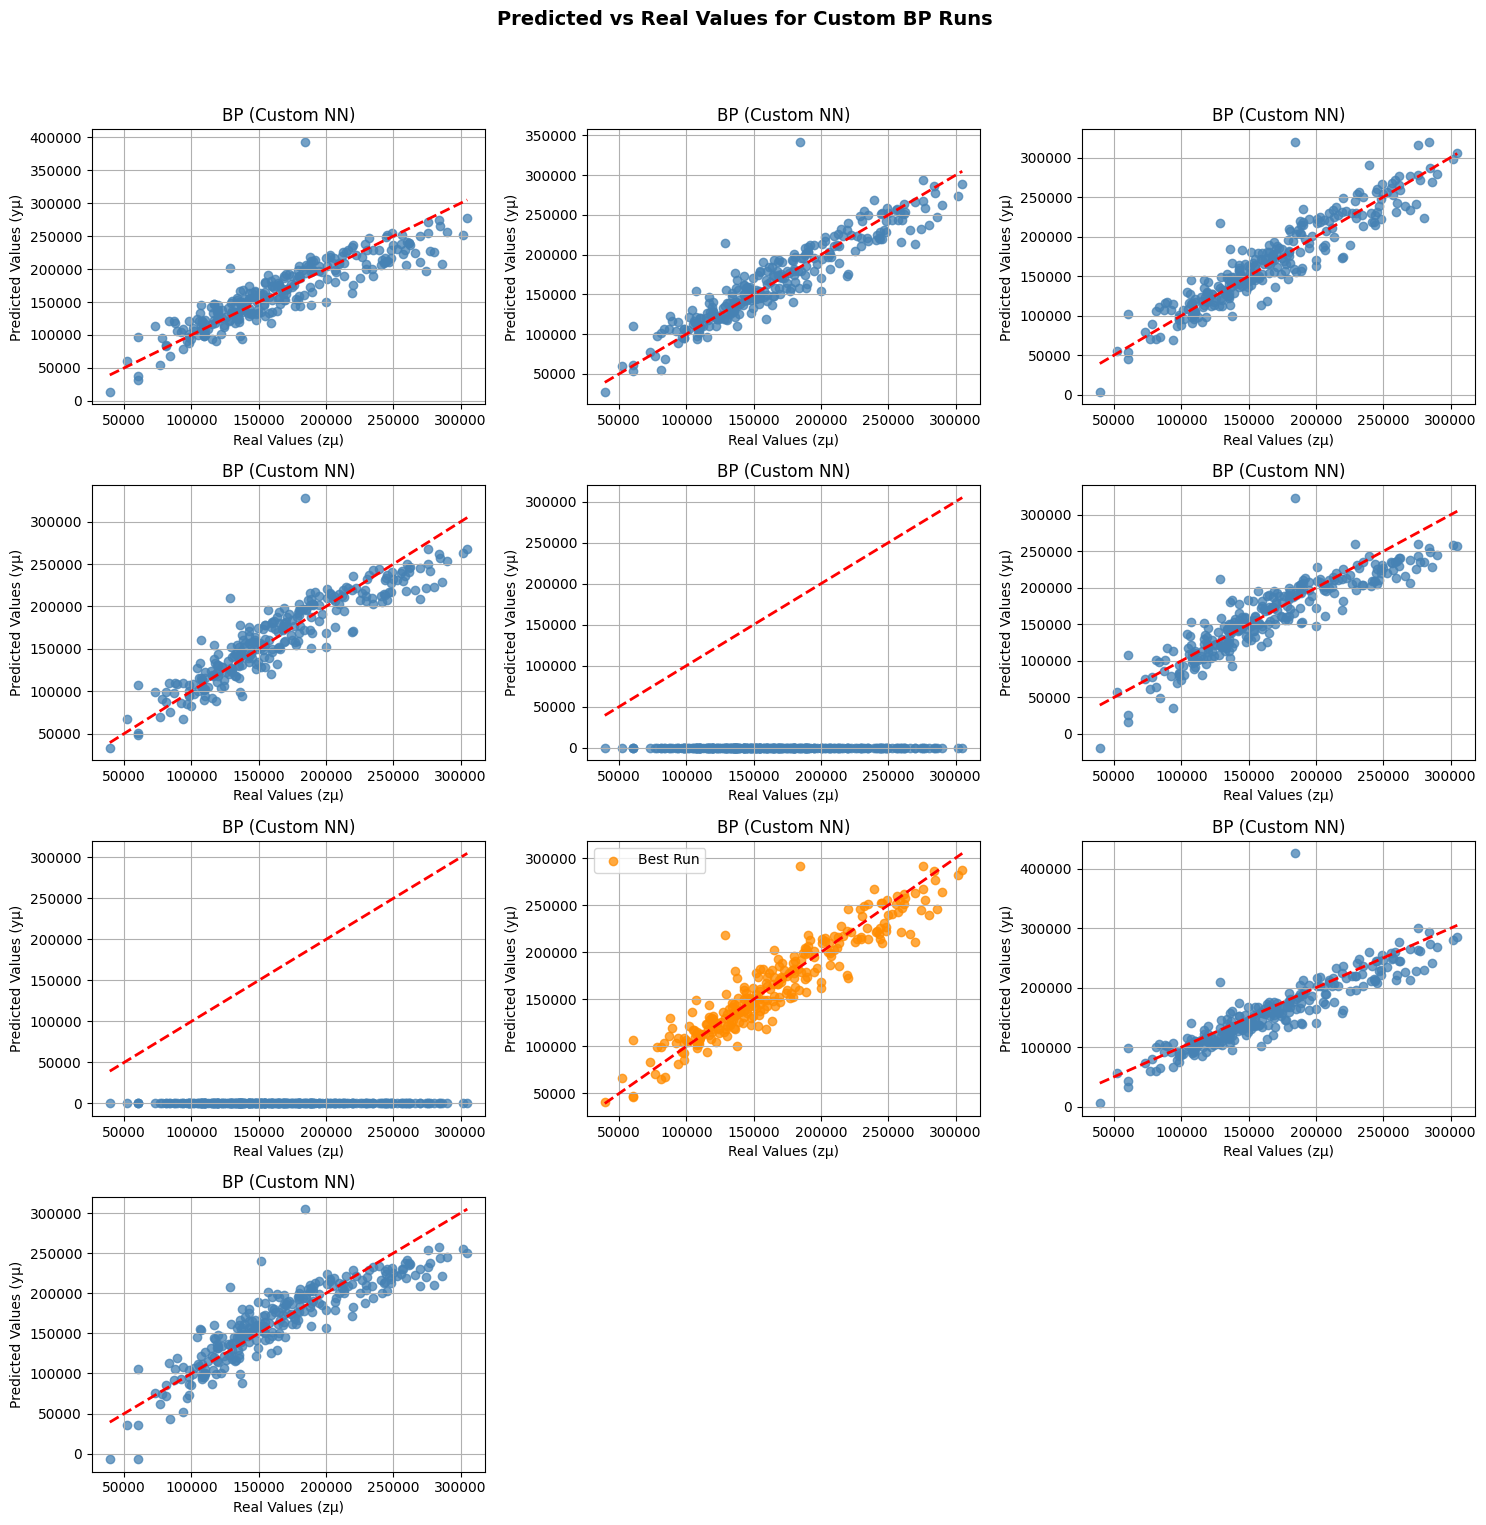

In [53]:
import math
# Denormalize the data
y_test_den = denormalize(y_test, 'SalePrice')

# Find index of best run (lowest MSE)
mse_list = [mean_squared_error(y_test_den, res['Pred Test'].flatten()) for res in custom_results]
best_idx = np.argmin(mse_list)

# Plot settings
n_results = len(custom_results)
cols = 3
rows = math.ceil(n_results / cols)
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axes = axes.flatten()  # flatten in case rows > 1

for i, res in enumerate(custom_results):
    y_pred = res['Pred Test']
    name = res['Model']

    ax = axes[i]
    # Highlight the best run
    if i == best_idx:
        scatter_color = 'darkorange'
        marker = 'o'
        label = 'Best Run'
    else:
        scatter_color = 'steelblue'
        marker = 'o'
        label = None

    ax.scatter(y_test_den, y_pred.flatten(), color=scatter_color, alpha=0.75, marker=marker, label=label)
    ax.plot([y_test_den.min(), y_test_den.max()], [y_test_den.min(), y_test_den.max()], 'r--', lw=2)
    ax.set_title(f"{name}")
    ax.set_xlabel("Real Values (zμ)")
    ax.set_ylabel("Predicted Values (yμ)")
    ax.grid(True)
    if i == best_idx:
        ax.legend()

# Remove empty subplots if n_results < rows*cols
for j in range(n_results, rows * cols):
    fig.delaxes(axes[j])

plt.suptitle("Predicted vs Real Values for Custom BP Runs", fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

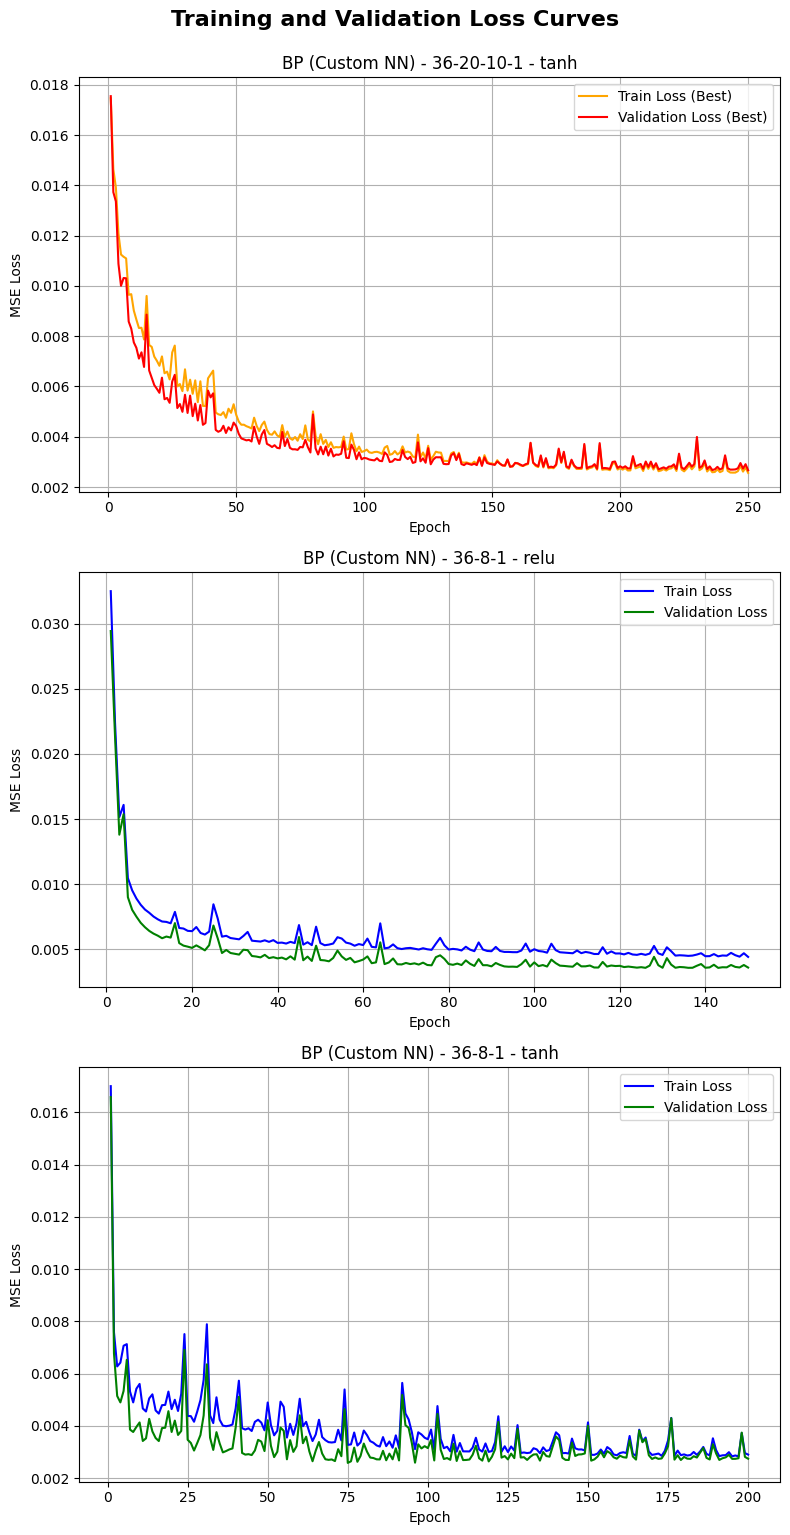

In [57]:
# Plot the training and validation curves for three different set of hyperparameters (indicating the best one of all of them)
other_runs = [res for res in custom_results if not np.array_equal(res['Pred Test'], best_metrics_bp['Pred Test'])]
runs_to_plot = [best_metrics_bp] + other_runs[:2]

plt.figure(figsize=(8, 5 * len(runs_to_plot)))

for idx, run in enumerate(runs_to_plot):
    train_losses = run['Train Losses']
    val_losses = run['Test Losses']
    epochs = range(1, len(train_losses) + 1)
    
    # Highlight the best run
    is_best = run is best_metrics_bp
    color_train = 'orange' if is_best else 'blue'
    color_val = 'red' if is_best else 'green'
    label_train = 'Train Loss (Best)' if is_best else 'Train Loss'
    label_val = 'Validation Loss (Best)' if is_best else 'Validation Loss'
    
    plt.subplot(len(runs_to_plot), 1, idx + 1)
    plt.plot(epochs, train_losses, label=label_train, color=color_train)
    plt.plot(epochs, val_losses, label=label_val, color=color_val)
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title(f"{run['Model']} - {format_layers(run.get('Layers'))} - {run['Activation']}")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.suptitle("Training and Validation Loss Curves", fontsize=16, fontweight='bold', y=1.02)
plt.show()

### Results comparing the different models

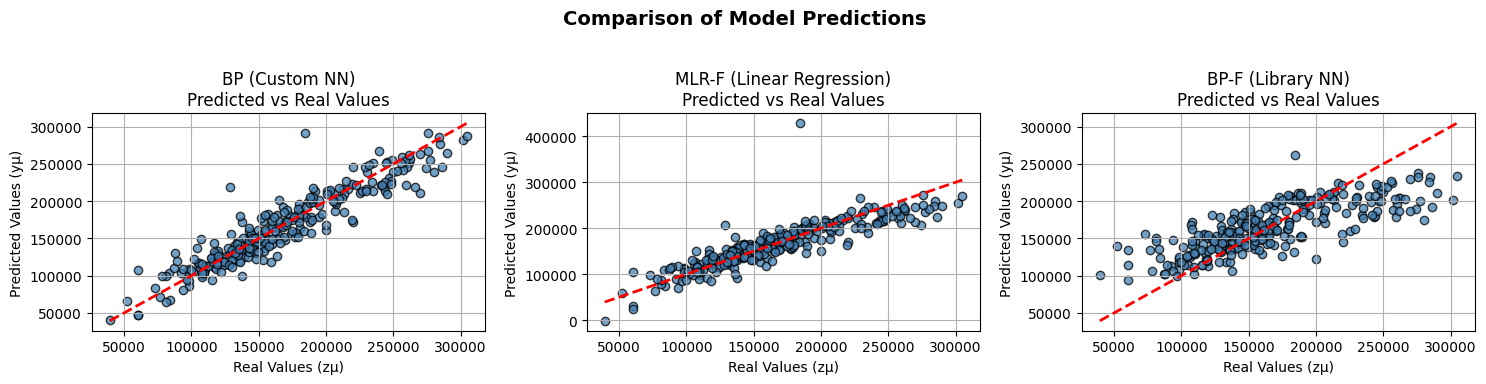

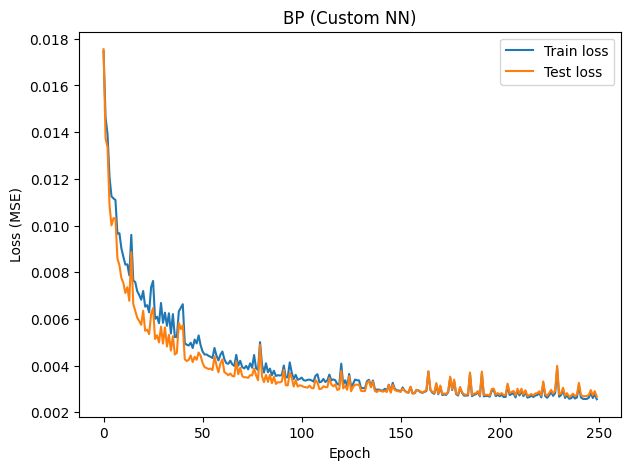

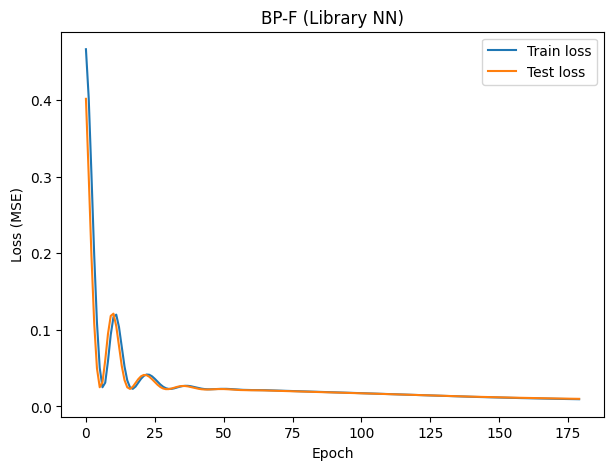

In [35]:
# Visualization: Scatter plots yμ vs zμ

models = {
    'BP (Custom NN)': results_list[0]['Pred Test'],
    'MLR-F (Linear Regression)': results_list[1]['Pred Test'],
    'BP-F (Library NN)': results_list[2]['Pred Test']
}

plt.figure(figsize=(15, 4))

# Denormalize the data
y_test_den = denormalize(y_test, 'SalePrice')
for i, (name, y_pred) in enumerate(models.items()):
    plt.subplot(1, 3, i + 1)
    plt.scatter(y_test_den, y_pred.flatten(), color='steelblue', edgecolors='k', alpha=0.75)
    plt.plot([y_test_den.min(), y_test_den.max()], [y_test_den.min(), y_test_den.max()], 'r--', lw=2)
    plt.title(f"{name}\nPredicted vs Real Values")
    plt.xlabel("Real Values (zμ)")
    plt.ylabel("Predicted Values (yμ)")
    plt.grid(True)

plt.suptitle("Comparison of Model Predictions", fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

def loss_curve(train_losses, test_losses, title):
    plt.figure(figsize=(7,5))
    plt.plot(train_losses, label='Train loss')
    plt.plot(test_losses, label='Test loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.title(title)
    plt.legend()
    plt.show()

custom_bp = results_list[0]  # Best BP model
bp_f = results_list[2]  # Best BP-F model

loss_curve(custom_bp['Train Losses'], custom_bp['Test Losses'], 'BP (Custom NN)')
loss_curve(bp_f['Train Losses'], bp_f['Test Losses'], 'BP-F (Library NN)')